In [1]:
import custom_style; 
custom_style.style()

In [2]:
import os
import sys
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint

import datetime
import glob

from ipywidgets import widgets
from IPython.display import display
from ipywidgets.widgets import interact

import gui_widgets
import load_handler

In [3]:
%gui qt

## Loading FITS folder

In [4]:
default_dir = '/Volumes/my_book_thunderbolt_duo/IPTS/'

In [5]:
%gui qt
dir_name = gui_widgets.gui_dname(dir = default_dir)
base_name = os.path.basename(dir_name)

# get list of files (*.fits)
list_files = glob.glob(dir_name + "/*.fits")

# remove from list *_SummedImg.fits fille
list_files = [file for file in list_files if not "_SummedImg.fits" in file] 

# =================================
# Load Data
# =================================
w = widgets.IntProgress(descrption='Loading data')
w.max = len(list_files)
display(w)

data = []
for _index, _file in enumerate(list_files):
    _image = load_handler.load_data(_file)
    data.append(_image)
    w.value = _index + 1

w.visible = False

### Crop Region

[0, 19, 0, 19]

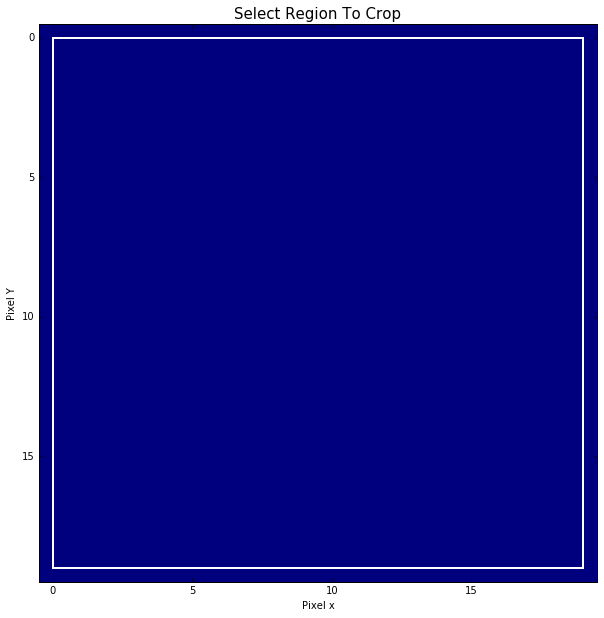

In [6]:
[height, width] = data[0].shape

def plot_image_for_cropping(file_index, x_left, x_right, y_top, y_bottom):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Region To Crop", fontsize=15)
    ax_img.set_xlabel("Pixel x")
    ax_img.set_ylabel("Pixel Y")
 
    _rectangle = patches.Rectangle(
        (x_left, y_top),
        x_right - x_left,
        y_bottom - y_top,
        edgecolor = "white",
        linewidth = 2,
        fill = False)
    ax_img.add_patch(_rectangle)

    return [x_left, x_right, y_top, y_bottom]

number_of_files = len(list_files)
crop = interact(plot_image_for_cropping,
        file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='Image index'),
        x_left = widgets.IntSlider(min=0, max=width-1, step=1, value=295),
        x_right = widgets.IntSlider(min=0, max=width-1, step=1, value=445),
        y_top = widgets.IntSlider(min=0, max=height-1, step=1, value=5), 
        y_bottom = widgets.IntSlider(min=0, max=height-1, step=1, value=500))

In [9]:
[x_left, x_right, y_top, y_bottom] = crop.widget.result

w = widgets.IntProgress(descrption='Cropping data')
w.max = len(list_files)
display(w)

# calculate cropped regions
cropped_data = []
for index, _data in enumerate(data):
    _cropped = _data[y_top:y_bottom+1, x_left:x_right+1]
    cropped_data.append(_cropped)
    w.value = index
    
w.visible = False

[height, width] = np.shape(cropped_data[0])

#### Checking cropping region 

[0, 19, 0, 19]

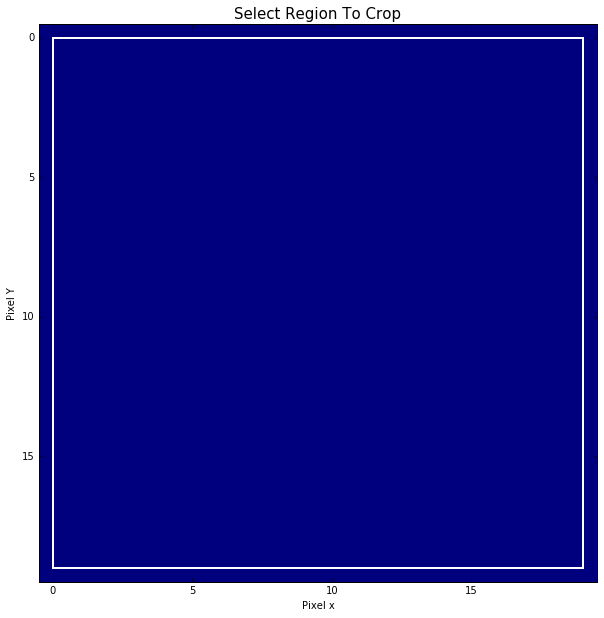

In [10]:
def plot_image_for_cropping(file_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(cropped_data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Region To Crop", fontsize=15)
    ax_img.set_xlabel("Pixel x")
    ax_img.set_ylabel("Pixel Y")
 
    _rectangle = patches.Rectangle(
        (x_left, y_top),
        x_right - x_left,
        y_bottom - y_top,
        edgecolor = "white",
        linewidth = 2,
        fill = False)
    ax_img.add_patch(_rectangle)

    return [x_left, x_right, y_top, y_bottom]

number_of_files = len(list_files)
check = interact(plot_image_for_cropping,
        file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='Image index'))


### Binning 

In [15]:
bin_value = 5       # pixels x pixels

In [16]:
print("RECAPITULATION")
print("==============")
print("> Width of ROI is: {}".format(width))
print("> Height of ROI is: {}".format(height))
print("> Bin size is {}x{}".format(bin_value, bin_value))
number_x_bin = int(width / bin_value)
print("> Number of bins in the X direction is: {}".format(number_x_bin))
number_y_bin = int(height / bin_value)
print("> Number of bins in the Y direction is: {}".format(number_y_bin))

RECAPITULATION
> Width of ROI is: 20
> Height of ROI is: 20
> Bin size is 5x5
> Number of bins in the X direction is: 4
> Number of bins in the Y direction is: 4


### Preview of ROIs

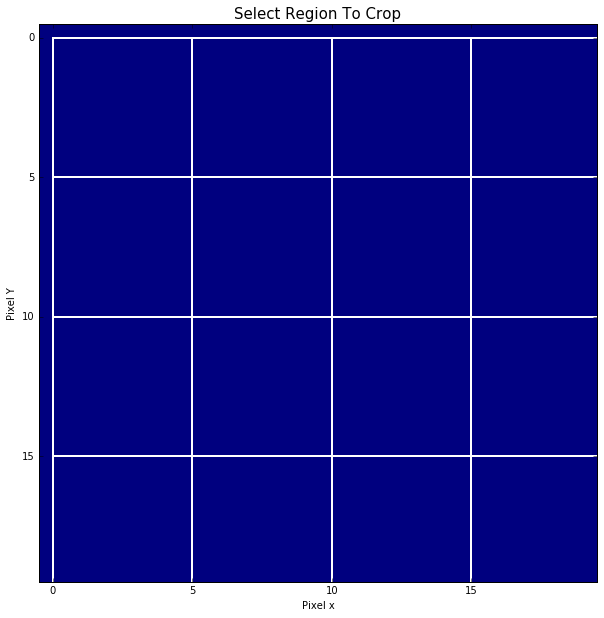

In [17]:
def preview_image_binning(file_index):
    
    fig = plt.figure(figsize=(10,10))
    ax_img = plt.subplot(111)
    ax_img.imshow(cropped_data[file_index])
    
#    _title = os.path.basename(list_files[file_index])
#    ax_img.set_title(_title)
    ax_img.set_title("Select Region To Crop", fontsize=15)
    ax_img.set_xlabel("Pixel x")
    ax_img.set_ylabel("Pixel Y")
 
    for x_offset in np.arange(number_x_bin):
        for y_offset in np.arange(number_y_bin):
        
            x_left = x_offset * bin_value
            x_right = (x_offset + 1) * bin_value
            y_top = y_offset * bin_value
            y_bottom = (y_offset + 1) * bin_value
        
            _rectangle = patches.Rectangle(
            (x_left, y_top),
            x_right - x_left,
            y_bottom - y_top,
            edgecolor = "white",
            linewidth = 2,
            fill = False)
            ax_img.add_patch(_rectangle)

number_of_files = len(list_files)
check = interact(preview_image_binning,
        file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='File index'))
 

### Preview of Bragg Edges Curves (row by row)

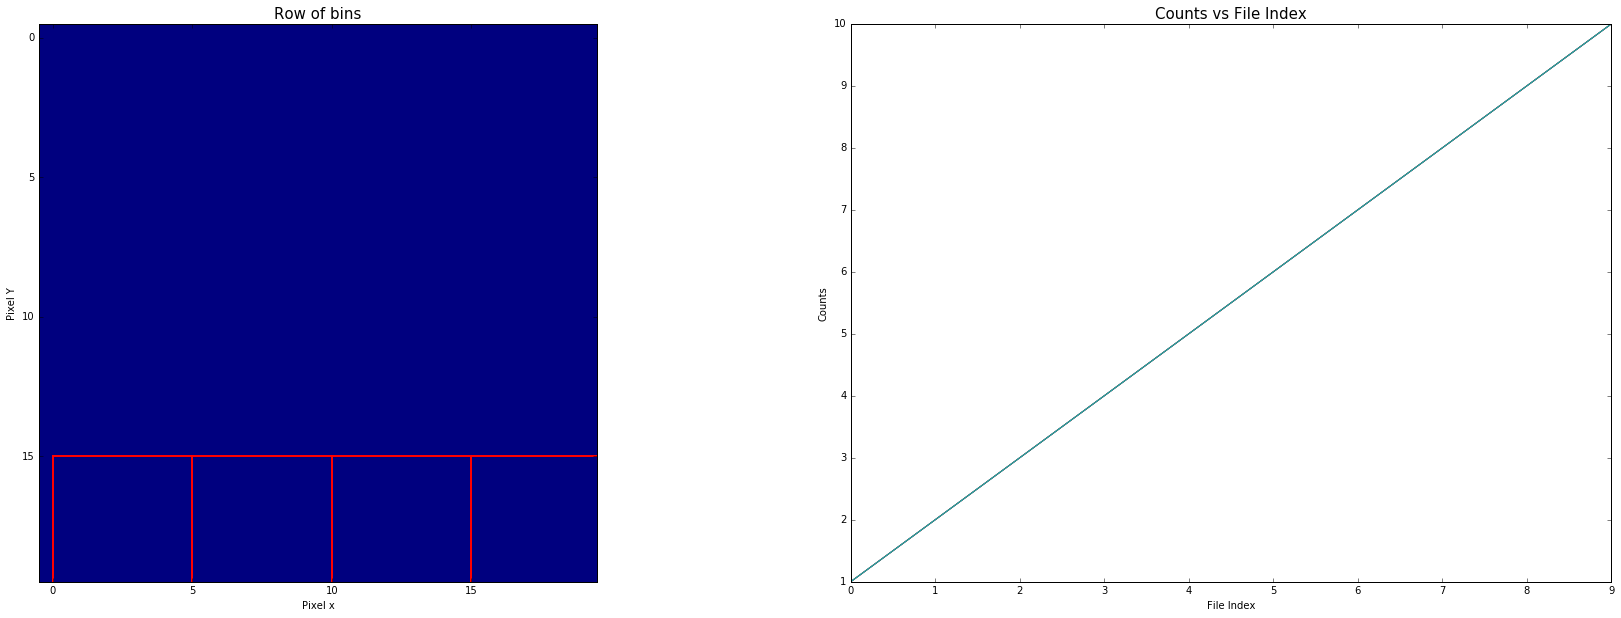

In [19]:
def get_data_for_row(row_index):
    counts_vs_file_index_data = []
    for number_x in np.arange(number_x_bin):
        counts_vs_file = []
        for _data in cropped_data:
            x_left = number_x * bin_value
            x_rigth = (number_x + 1) * bin_value
            y_top = row_index * bin_value
            y_bottom = (row_index + 1) * bin_value
            
            counts = np.mean(_data[y_top:y_bottom, x_left:x_right])
            counts_vs_file.append(counts)
        counts_vs_file_index_data.append(counts_vs_file)
    return counts_vs_file_index_data

def preview_bragg_edges_row_by_row(file_index, row_index):
    
    counts_vs_file_index_data = get_data_for_row(row_index)
    
    fig = plt.figure(figsize=(30,10))
    ax_img = plt.subplot(121)
    ax_img.imshow(cropped_data[file_index])
    ax_img.set_title("Row of bins", fontsize=15)
    ax_img.set_xlabel("Pixel x")
    ax_img.set_ylabel("Pixel Y")

    ax_plot = plt.subplot(122)
    for _plot in counts_vs_file_index_data:
        ax_plot.plot(_plot)
    ax_plot.set_title("Counts vs File Index", fontsize=15)
    ax_plot.set_xlabel("File Index")
    ax_plot.set_ylabel("Counts")
 
    for x_offset in np.arange(number_x_bin):
    
        x_left = x_offset * bin_value
        x_right = (x_offset + 1) * bin_value
        y_top = row_index * bin_value
        y_bottom = (row_index + 1) * bin_value
        
        _rectangle = patches.Rectangle(
            (x_left, y_top),
            x_right - x_left,
            y_bottom - y_top,
            edgecolor = "red",
            linewidth = 2,
            fill = False)
        ax_img.add_patch(_rectangle)

check = interact(preview_bragg_edges_row_by_row,
            file_index =widgets.IntSlider(min=0, 
                                      max=number_of_files-1,
                                      step=1, value=0, 
                                      description='File index'),
             row_index =widgets.IntSlider(min=0, 
                                      max=number_y_bin-1,
                                      step=1, value=0, 
                                      description='Row index'))

### Export Data 

##### Select where to put the ascii files 

In [20]:
export_dir_name = gui_widgets.gui_dname(dir = default_dir)

In [21]:
print("RECAPITULATION")
print("==============")
print("> Notebook is about to create:")
print("> bin value: {} pixels x {} pixels".format(bin_value, bin_value))
print("> {} files (1 file = 1 row)".format(number_y_bin))
print("> Each file will contain {} columns (number of columns)".format(number_x_bin))
print("> Files will be created in this folder {}".format(export_dir_name))
print("> Base name of files will be:")
print("       -> {}_row_000.csv".format(base_name))
print("       -> {}_row_001.csv".format(base_name))
print("       -> {}_row_002.csv".format(base_name))

RECAPITULATION
> Notebook is about to create:
> bin value: 5 pixels x 5 pixels
> 4 files (1 file = 1 row)
> Each file will contain 4 columns (number of columns)
> Files will be created in this folder /Users/j35/Desktop
> Base name of files will be:
       -> FITSimages_row_000.csv
       -> FITSimages_row_001.csv
       -> FITSimages_row_002.csv


In [22]:
def export_row_data(file_name = '', data = []):
    f = open(file_name, 'w')
    text = "# input folder: {}\n".format(base_name)
    text += "# bin size: {} pixels x {} pixels\n".format(bin_value, bin_value)
    text += "#\n"
    text += '# file_index column_data\n'
    
    [nbr_col, nbr_data] = np.shape(data)
    for _index_row in np.arange(nbr_data):
        text += "{}".format(_index_row)
        for _index_col in np.arange(nbr_col):
            _data = data[_index_col]
            text += ",{}".format(_data[_index_row])
        text += "\n"
    
    f.write(text)
    f.close()

def make_export_file_name(export_dir_name, base_name, index):
    _short_file_name = base_name + "_row_{:03d}.csv".format(index)
    return os.path.join(export_dir_name, _short_file_name)

w = widgets.IntProgress(descrption='Cropping data')
w.max = number_y_bin
display(w)

for _row in np.arange(number_y_bin):
    export_file_name = make_export_file_name(export_dir_name, base_name, _row)
    row_data = get_data_for_row(_row)
    export_row_data(file_name = export_file_name,
                   data = row_data)
    w.value = _row

w.visible = False